In [1]:
# use lod env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Calculate potential index for each wall

The index is combined out of the following factors:
* solid wall area below 12m: the estimated area that could be used for greenery for this wall in m². The higher it is, the lower the costs for setting up greenery per m² and the higher the benefit
* window-to-wall ratio (wwr_corrected): the lower the WWR is (fewer windows and doors), the lower the maintenance effort and costs
* orientation: the more south oriented the wall is, the higher the benefit for heat stress reduction
* outside groundbound: if it is not groundbound, the potential is 0 since no vertical greenery is possible
* small wwr_extraction bonus: if the wwr was actually extracted and not just estimated, the probabilitity that the wwr value is correct is higher and it therefore gets a slightly higher index

For this:
* the first three factors are scaled to be from 0 to 1, 1 being the best possible value
* an index is built by combining those scaled factors
* the bonus for wwr_extraction is applied
* the outside_groundbound factor is applied (sets those that are not outside groundbound to 0)

In [7]:
# paths
data_dir = "./../data"
dataframes_dir = data_dir + "/dataframes"
figures_dir = data_dir + "/figures"

# read data in
df2_walls = pd.read_csv(dataframes_dir + "/df2_walls_05_with_image_factors.csv")
df2_walls

,part_id,wall_id,surface_coordinates,area,normal_vec,wall_height,angle_to_north,cardinal_direction,outside_surface_coordinates,outside_area,outside_subtracted_walls,outside,outside_groundbound,outside_bounding_box,interesting_for_image,camera_id_for_image,wwr_extracted,solid_wall_area
0,DESN_0002JBA_main,UUID_f78f441e-a31c-49c4-891a-79bed64cfee6,"[(311357.95, 5687941.966, 124.984), (311360.34...",53.802405,"[0.977620952048355, 0.21037412891339127, 0.0]",4.722,77.855722,west,"[[(311357.95, 5687941.966, 124.984), (311360.3...",53.802405,[],True,True,"[(311357.95, 5687941.966, 124.984), (311360.34...",True,WE974KVK,0.1331,46.641305
1,DESN_0017TMK_main,UUID_596a0c96-2b08-44d3-b9d8-7af3ee287f8b,"[(311897.827, 5687962.987, 128.311), (311896.3...",34.152762,"[-0.9842458844111843, -0.1768050876520403, 0.0]",3.957,259.816280,east,"[[(311897.827, 5687962.987, 128.311), (311896....",34.152762,[],True,True,"[(311897.827, 5687962.987, 128.311), (311896.3...",True,WE974K4L,0.0000,34.152762
2,DESN_0002QF1_main,UUID_a66ff14a-78db-4f8b-95c9-eacee0cf2164,"[(310283.452, 5688672.406, 126.564), (310281.5...",27.084408,"[-0.9799136722838616, -0.1994221524082937, 0.0]",2.893,258.496830,east,"[[(310283.452, 5688672.406, 126.564), (310281....",27.084408,[],True,True,"[(310283.452, 5688672.406, 126.564), (310281.5...",True,WE9546CC,0.1988,21.700028
3,DESN_0002NB4_main,UUID_a2e83c6d-cf60-467e-bfc4-d22c99a4b591,"[(310136.242, 5688393.021, 127.047), (310138.7...",56.228536,"[0.9785119739143929, 0.20619000195489243, 0.0]",4.658,78.100830,west,"[[(310136.242, 5688393.021, 127.047), (310138....",56.228536,[],True,True,"[(310136.242, 5688393.021, 127.047), (310138.7...",True,WE979T8Y,0.0687,52.365636
4,DESN_0002NTZ_main,UUID_0a449ab8-1982-40b6-9fc9-208a27aa2220,"[(310388.526, 5688185.182, 128.188), (310376.0...",85.639142,"[0.364680580739679, -0.9311326833654646, 0.0]",6.388,158.612074,south,"[[(310388.526, 5688185.182, 128.188), (310376....",85.639142,[],True,True,"[(310388.526, 5688185.182, 128.188), (310376.0...",True,WE979S28,0.1815,70.095638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106230,DESN_{FF43462A-C355-4EF2-9611-3614E334E9CA}_main,combined_147998,"[(310959.361, 5692372.631, 112.839), (310949.9...",78.164957,"[-0.06276707232088058, -0.9980282033250689, 0.0]",9.392,183.598654,south,"[[(310959.361, 5692372.631, 112.839), (310949....",78.164957,[],True,True,"[(310959.361, 5692372.631, 122.231), (310949.9...",True,WE6H29F5,0.0194,76.648557
106231,DESN_{FF488292-F797-4E7A-BF60-B682A5498601}_main,combined_148000,"[(323894.564, 5688558.356, 134.306), (323894.5...",27.640899,"[-0.2637426022307864, -0.9645930954389696, 0.0]",8.263,195.292251,south,"[[(323894.564, 5688558.356, 134.306), (323894....",27.640899,[],True,True,"[(323897.962, 5688557.427, 142.569), (323894.5...",True,WE923SOI,0.1098,24.605928
106232,DESN_{FFA003C7-EE6B-4E71-B161-6F8DE0A33E7F}_main,combined_148014,"[(308678.735, 5689366.104, 117.924), (308681.1...",105.799422,"[0.9710427589411436, 0.23890575612147164, 0.0]",11.390,76.178034,west,"[[(308678.735, 5689366.104, 117.924), (308681....",105.799422,[],True,True,"[(308678.735, 5689366.104, 129.314), (308681.1...",True,WE6K2FDN,0.0340,102.202242
106233,DESN_{FFA003C7-EE6B-4E71-B161-6F8DE0A33E7F}_main,combined_148015,"[(308647.212, 5689347.564, 117.924), (308644.6...",109.122546,"[-0.9687506448683842, -0.24803666677951025, 0.0]",11.390,255.638637,east,"[[(308647.212, 5689347.564, 117.924), (308644....",109.122546,[],True,True,"[(308647.212, 5689347.564, 129.314), (308644.6...",True,WE6K2FE0,0.0192,107.027393


## Scale main factors 

In [3]:
def plot_hist(data, bins = 50, title = "Histogram", x = "Factor", y = "Number of walls", save_path = None, ylog = False):
    ''' 
    Plots and displays a histogram using the provided data, with an option to save the figure.

    PARAMS:
    * data: A 1D array-like structure containing the data to be plotted in the histogram.
    * bins: (Optional) An integer specifying the number of bins to use for the histogram (default is 50).
    * title: (Optional) A string representing the title of the histogram (default is "Histogram").
    * x: (Optional) A string representing the label for the x-axis (default is "Factor").
    * y: (Optional) A string representing the label for the y-axis (default is "Number of walls").
    * save_path: (Optional) A string representing the file path where the histogram image will be saved. If None, the histogram will not be saved.
    * ylog: (Optional) A boolean indicating whether to use a logarithmic scale for the y-axis (default is False).
    '''
    # make hist
    plt.hist(data, bins = bins, alpha=0.9, edgecolor='black')

    # add title and axis labels
    # set text sizes quite high so that they are still readable if plots are shown rather small in thesis
    plt.title(title, fontsize = 17)
    plt.xlabel(x, fontsize = 15)
    plt.ylabel(y, fontsize = 15)
    plt.yticks(fontsize = 13)
    plt.xticks(fontsize = 13)

    # x axis should always start with 0
    plt.xlim(0)

    # make y a log scale if wanted
    if ylog:
        plt.yscale('log')

    plt.tight_layout()

    # save figure if wanted
    if save_path is not None:
        plt.savefig(save_path)#, transparent = True)
        
    plt.show()

### Solid wall area

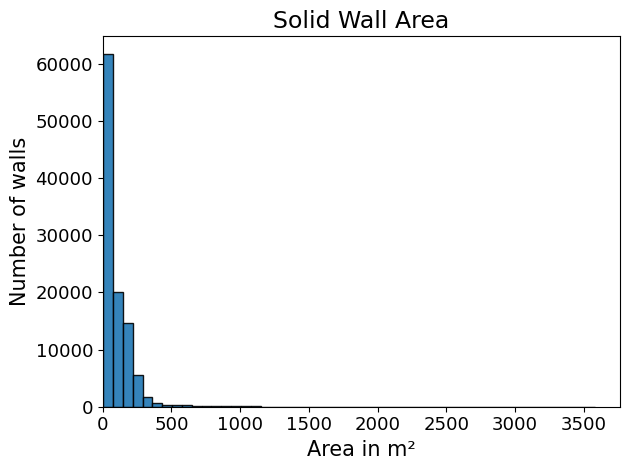

In [8]:
# look at factor
plot_hist(df2_walls["solid_wall_area"], x = "Area in m²", title = "Solid Wall Area", save_path=figures_dir + "/swa_orig.png")

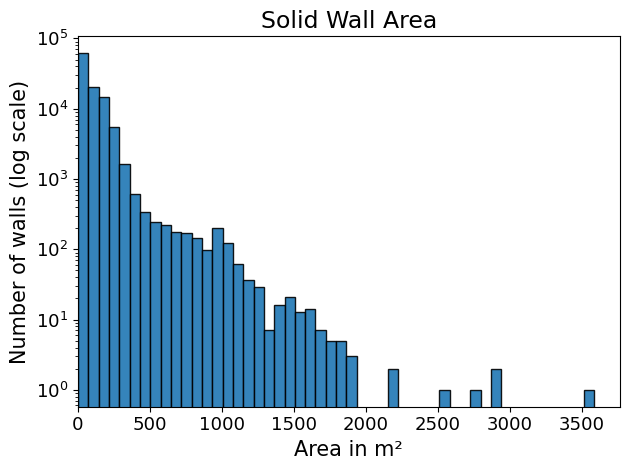

In [9]:
# look at factor - log
plot_hist(df2_walls["solid_wall_area"], x = "Area in m²", y = "Number of walls (log scale)", title = "Solid Wall Area", save_path=figures_dir + "/swa_orig_log.png", ylog=True)

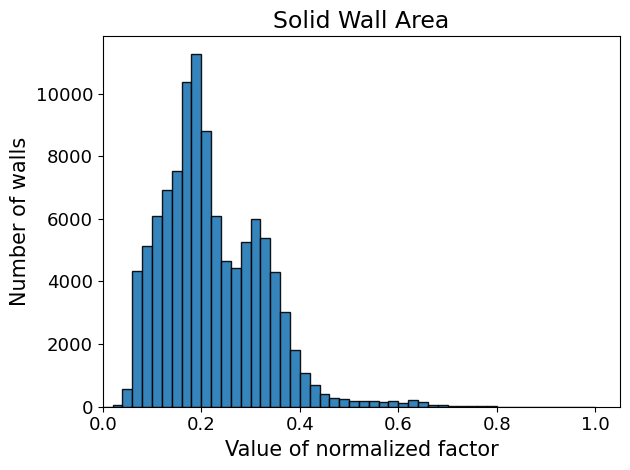

In [10]:
# the extremes can not stay so extreme, but a log conversion would reduce the values that stand for really good walls for vertical greenery too much, a power transformation with exponent of 0.3 was chosen, followed by a min-max normalisation
solid_wall_area_factor = df2_walls["solid_wall_area"]**0.3
solid_wall_area_factor = (solid_wall_area_factor - min(solid_wall_area_factor)) / (max(solid_wall_area_factor) - min(solid_wall_area_factor))
plot_hist(solid_wall_area_factor, x = "Value of normalized factor", title = "Solid Wall Area", save_path=figures_dir + "/swa_norm.png")

### wwr

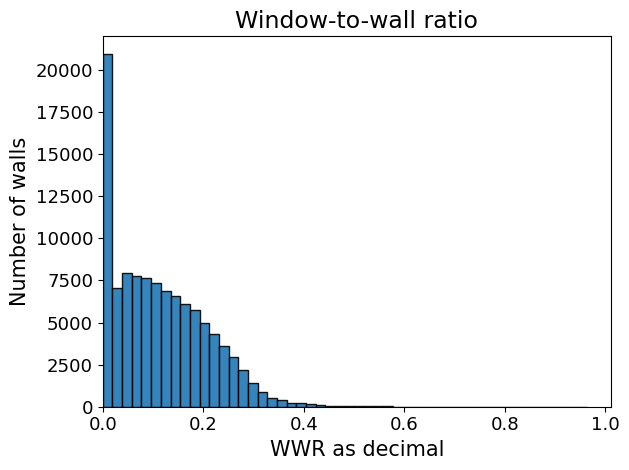

In [11]:
# look at factor
plot_hist(df2_walls["wwr_extracted"], x = "WWR as decimal", title = "Window-to-wall ratio", save_path=figures_dir + "/wwr_orig.png")

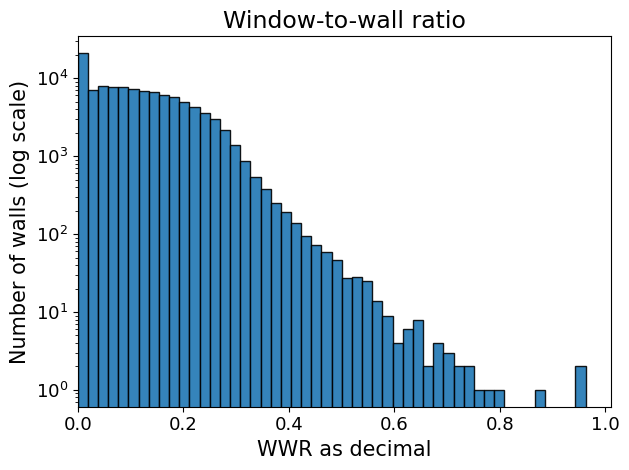

In [12]:
# look at factor
plot_hist(df2_walls["wwr_extracted"], x = "WWR as decimal", y = "Number of walls (log scale)", title = "Window-to-wall ratio", save_path=figures_dir + "/wwr_orig_log.png", ylog=True)

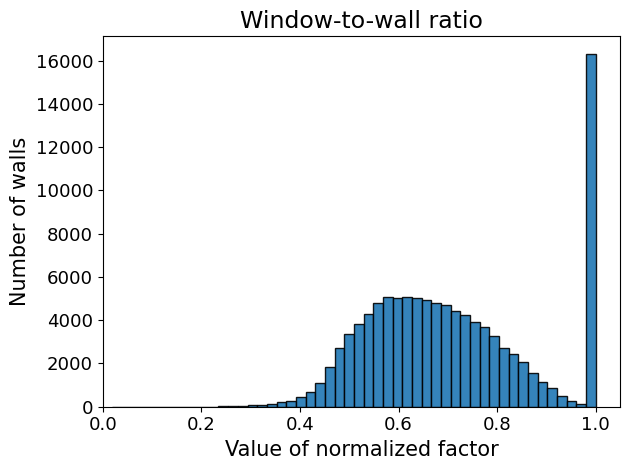

In [13]:
# take squareroot in order to span the range of most WWRs over a bigger range (-> counts more towards end index)
wwr_factor = df2_walls["wwr_extracted"]**0.5
# the factor needs to be reversed as a low wwr means a high score
wwr_factor = 1-wwr_factor
plot_hist(wwr_factor, x = "Value of normalized factor", title = "Window-to-wall ratio", save_path=figures_dir + "/wwr_norm.png")

### orientation

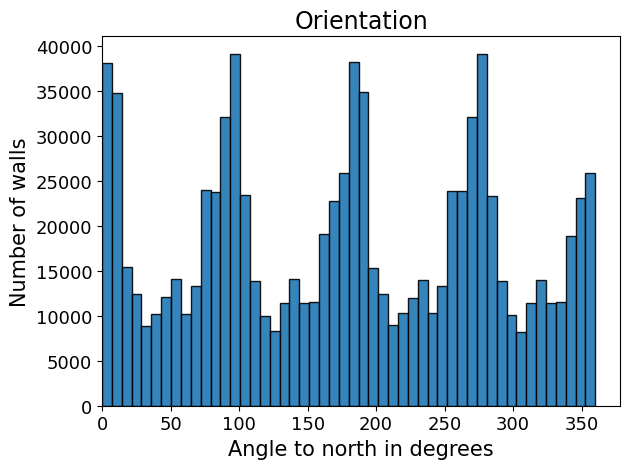

In [10]:
# look at factor
plot_hist(df2_walls["angle_to_north"], x = "Angle to north in degrees", title = "Orientation", save_path=figures_dir + "/orientation_orig.png")

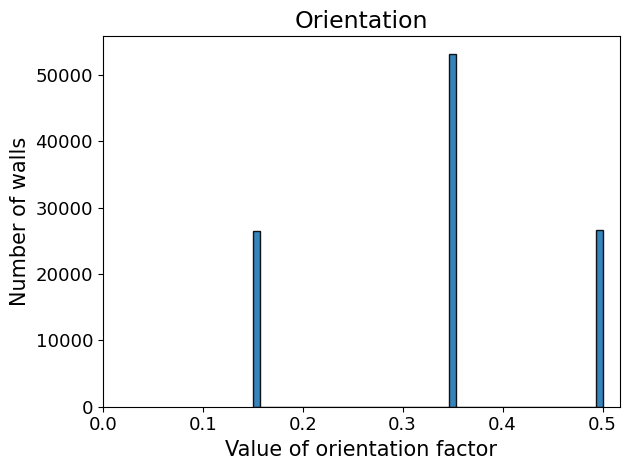

In [15]:
# Assign values / weights to each cardinal direction giving south facing walls the best value, and north facing walls the least favorable
# Conditions
conditions = [
    (df2_walls["angle_to_north"].between(0, 45)) | (df2_walls["angle_to_north"].between(315, 360)),  # North
    df2_walls["angle_to_north"].between(45, 135),   # West
    df2_walls["angle_to_north"].between(135, 225),  # South
    df2_walls["angle_to_north"].between(225, 315)  # East
]

# Corresponding factors
factors = [0.15, 0.35, 0.35, 0.5]

orientation_factor = np.select(conditions, factors, default=np.nan)
plot_hist(orientation_factor,  x = "Value of orientation factor", title = "Orientation", save_path=figures_dir + "/orientation_norm.png") 

## Combine into index
Index is computed as weighted sum with weights applied for each of the factors

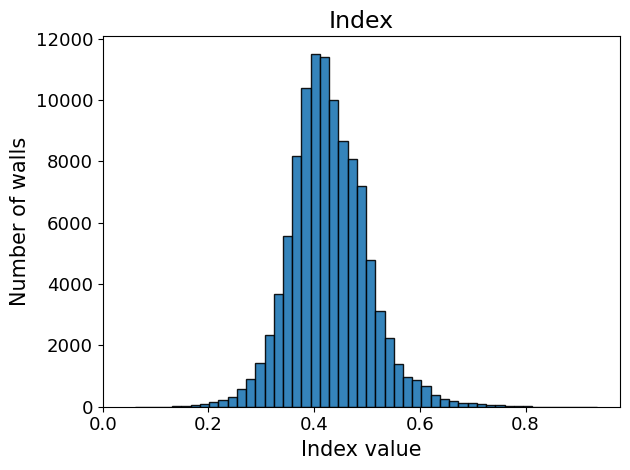

In [16]:
# set weights           
# swa = 0.5, wwr = 0.4, orientation = 0.1
factor_weights = np.array([0.50, 0.40, 0.1])
factors_transformed = np.vstack([solid_wall_area_factor, wwr_factor, orientation_factor ]).T  # shape (N, K)

index_weighted_sum = factors_transformed @ factor_weights

plot_hist(index_weighted_sum, x = "Index value", title = "Index", save_path=figures_dir + "/index_weighted_sum.png") 

In [17]:
# add a rank to have something like a priority list, 1 is the wall with the highest potential
index_rank = (pd.Series(index_weighted_sum)).rank(ascending = False)
index_rank

0         82157.0
1          8920.0
2         99322.0
3         52490.0
4         84515.0
           ...   
106230    17771.0
106231    88821.0
106232    18592.0
106233     8615.0
106234    54199.0
Length: 106235, dtype: float64

In [18]:
# include into df and save
df2_walls["potential_index"] = index_weighted_sum
df2_walls["potential_rank"] = [int(rank) for rank in index_rank]
df2_walls.to_csv(dataframes_dir + "/df2_walls_06_with_all_factors_and_potential_index.csv", index = False)

In [19]:
df2_walls

,part_id,wall_id,surface_coordinates,area,normal_vec,wall_height,angle_to_north,cardinal_direction,outside_surface_coordinates,outside_area,outside_subtracted_walls,outside,outside_groundbound,outside_bounding_box,interesting_for_image,camera_id_for_image,wwr_extracted,solid_wall_area,potential_index,potential_rank
0,DESN_0002JBA_main,UUID_f78f441e-a31c-49c4-891a-79bed64cfee6,"[(311357.95, 5687941.966, 124.984), (311360.34...",53.802405,"[0.977620952048355, 0.21037412891339127, 0.0]",4.722,77.855722,west,"[[(311357.95, 5687941.966, 124.984), (311360.3...",53.802405,[],True,True,"[(311357.95, 5687941.966, 124.984), (311360.34...",True,WE974KVK,0.1331,46.641305,0.376914,82157
1,DESN_0017TMK_main,UUID_596a0c96-2b08-44d3-b9d8-7af3ee287f8b,"[(311897.827, 5687962.987, 128.311), (311896.3...",34.152762,"[-0.9842458844111843, -0.1768050876520403, 0.0]",3.957,259.816280,east,"[[(311897.827, 5687962.987, 128.311), (311896....",34.152762,[],True,True,"[(311897.827, 5687962.987, 128.311), (311896.3...",True,WE974K4L,0.0000,34.152762,0.524113,8920
2,DESN_0002QF1_main,UUID_a66ff14a-78db-4f8b-95c9-eacee0cf2164,"[(310283.452, 5688672.406, 126.564), (310281.5...",27.084408,"[-0.9799136722838616, -0.1994221524082937, 0.0]",2.893,258.496830,east,"[[(310283.452, 5688672.406, 126.564), (310281....",27.084408,[],True,True,"[(310283.452, 5688672.406, 126.564), (310281.5...",True,WE9546CC,0.1988,21.700028,0.327939,99322
3,DESN_0002NB4_main,UUID_a2e83c6d-cf60-467e-bfc4-d22c99a4b591,"[(310136.242, 5688393.021, 127.047), (310138.7...",56.228536,"[0.9785119739143929, 0.20619000195489243, 0.0]",4.658,78.100830,west,"[[(310136.242, 5688393.021, 127.047), (310138....",56.228536,[],True,True,"[(310136.242, 5688393.021, 127.047), (310138.7...",True,WE979T8Y,0.0687,52.365636,0.423440,52490
4,DESN_0002NTZ_main,UUID_0a449ab8-1982-40b6-9fc9-208a27aa2220,"[(310388.526, 5688185.182, 128.188), (310376.0...",85.639142,"[0.364680580739679, -0.9311326833654646, 0.0]",6.388,158.612074,south,"[[(310388.526, 5688185.182, 128.188), (310376....",85.639142,[],True,True,"[(310388.526, 5688185.182, 128.188), (310376.0...",True,WE979S28,0.1815,70.095638,0.372435,84515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106230,DESN_{FF43462A-C355-4EF2-9611-3614E334E9CA}_main,combined_147998,"[(310959.361, 5692372.631, 112.839), (310949.9...",78.164957,"[-0.06276707232088058, -0.9980282033250689, 0.0]",9.392,183.598654,south,"[[(310959.361, 5692372.631, 112.839), (310949....",78.164957,[],True,True,"[(310959.361, 5692372.631, 122.231), (310949.9...",True,WE6H29F5,0.0194,76.648557,0.491858,17771
106231,DESN_{FF488292-F797-4E7A-BF60-B682A5498601}_main,combined_148000,"[(323894.564, 5688558.356, 134.306), (323894.5...",27.640899,"[-0.2637426022307864, -0.9645930954389696, 0.0]",8.263,195.292251,south,"[[(323894.564, 5688558.356, 134.306), (323894....",27.640899,[],True,True,"[(323897.962, 5688557.427, 142.569), (323894.5...",True,WE923SOI,0.1098,24.605928,0.363442,88821
106232,DESN_{FFA003C7-EE6B-4E71-B161-6F8DE0A33E7F}_main,combined_148014,"[(308678.735, 5689366.104, 117.924), (308681.1...",105.799422,"[0.9710427589411436, 0.23890575612147164, 0.0]",11.390,76.178034,west,"[[(308678.735, 5689366.104, 117.924), (308681....",105.799422,[],True,True,"[(308678.735, 5689366.104, 129.314), (308681.1...",True,WE6K2FDN,0.0340,102.202242,0.489915,18592
106233,DESN_{FFA003C7-EE6B-4E71-B161-6F8DE0A33E7F}_main,combined_148015,"[(308647.212, 5689347.564, 117.924), (308644.6...",109.122546,"[-0.9687506448683842, -0.24803666677951025, 0.0]",11.390,255.638637,east,"[[(308647.212, 5689347.564, 117.924), (308644....",109.122546,[],True,True,"[(308647.212, 5689347.564, 129.314), (308644.6...",True,WE6K2FE0,0.0192,107.027393,0.525959,8615
